### **Download Resources and Setup Environment**

In [ ]:
!pip install -qq ftfy regex tqdm
!pip install -qq transformers
!pip install wandb -qU
!pip install -qq evaluate
!pip install -qq pytorch-lightning==1.9.0
!pip install -qq torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.7 MB/s eta 0:00:00


In [ ]:
# Log in to Wandb account
import wandb
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login(key="42903b186341e2de0eb8023e18c7a95641e1ffd7")
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
%matplotlib inline

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os

**Define Base Models**

In [ ]:
from transformers import AutoTokenizer, OPTForCausalLM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
gpt_model = OPTForCausalLM.from_pretrained("facebook/opt-350m")


# Alternative
# tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
# from transformers import ViTModel, AutoImageProcessor

# image_encoder_model = "google/vit-base-patch16-224-in21k"

# image_processor = AutoImageProcessor.from_pretrained(image_encoder_model)
# vit_model = ViTModel.from_pretrained(image_encoder_model)

In [ ]:
from transformers import ConvNextModel, ConvNextFeatureExtractor

image_encoder_model = ConvNextModel.from_pretrained("facebook/convnext-base-224-22k-1k")

image_processor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-base-224-22k-1k")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


### **COCO Dataset**

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -qq annotations_trainval2017.zip

!mkdir images
%cd images

!gdown --id '1-DmIQ348eqDVuzNPhnx60K4k1s7ik7Fy' -O COCO_train.zip
!gdown --id '1-7M2pYpbmt7ziFjadR4BOvTmFv5tbptM' -O COCO_val.zip

!unzip -qq COCO_train.zip
!unzip -qq COCO_val.zip
%cd ..

--2023-11-21 19:54:02--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.137.33, 52.216.48.193, 52.217.80.236, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.137.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.5MB/s    in 2.5s    

2023-11-21 19:54:05 (96.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

/content/images
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-DmIQ348eqDVuzNPhnx60K4k1s7ik7Fy
To: /content/images/COCO_train.zip
100% 1.61G/1.61G [00:31<00:00, 51.0MB/s

Setup COCO Dataset API

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI/

!make -s
%cd /content/

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/cocoapi/PythonAPI
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-cpython-310
creating build/temp.linux-x86_64-cpython-310/pycocotools
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security 

In [ ]:
import torchtext
import os
import random
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from filelock import FileLock
from pycocotools.coco import COCO

random.seed(42)

class CocoImageCapDataset(Dataset):
    def __init__(self, tokenizer,
                 split: str, # train, val
                 max_length: int,
                 image_dir = '/content/images',
                 image_transform = None,
                 cache_path = None,
                 overwrite_cache = False):

        assert split in ['val', 'train'], 'invalid split'
        assert cache_path, 'provide a writtable cache path'

        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.split = split
        self.max_length = max_length
        self.image_dir = image_dir

        data_dir = '.'
        data_type = f'{split}2017'

        # Load image file with COCO api
        annFile='{}/annotations/instances_{}.json'.format(data_dir,data_type)
        self.coco_imgs = COCO(annFile)

        # Load Caption
        annFile = '{}/annotations/captions_{}.json'.format(data_dir,data_type)
        self.coco_caps = COCO(annFile)

        # Get list of indices of (img, caption) pair (COCO index don't start from 0)
        self.indices = self.coco_imgs.getImgIds()

        # ------TEMPORARY -----
        if split == 'train':
            self.indices = self.indices[:10000]
        else:
            self.indices = self.indices[:500]
        # ---------------------

        # # Cache tokenized sentences
        # cached_features_file = os.path.join(
        #     cache_path, "cached_toks_{}_{}".format(tokenizer.__class__.__name__, self.split))

        # In case of multi-threaded execution and to avoid recomputing this all the time.
        # lock_path = cached_features_file + ".lock"
        # with FileLock(lock_path):
        #     if os.path.exists(cached_features_file) and not overwrite_cache:
        #         with open(cached_features_file, "rb") as handle:
        #             self.tokenized_texts = torch.load(handle)
        #     else:
                # Tokenize and add examples to the local variables.
        self.tokenized_texts = list()
        self.images = list()

        for idx in self.indices:
            # Load and tokenize text
            annId = self.coco_caps.getAnnIds(imgIds=idx);
            anns = self.coco_caps.loadAnns(annId)
            rand_idx = random.randint(0, len(anns) - 1)
            text = anns[0]['caption']

            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True,
                max_length = max_length, padding = 'max_length',
                return_attention_mask = True, return_tensors = 'pt')

            self.tokenized_texts.append(encoded_text)

            # Download image (If not exist) and save image filename
            img = self.coco_imgs.loadImgs(idx)[0]
            img_path = os.path.join(f"{image_dir}/{split}", img['file_name'])

            # if not os.path.isfile(img_path):
            #     response = requests.get(img['coco_url'])
            #     with open(img_path, "wb") as f:
            #         f.write(response.content)

            self.images.append(img['file_name'])


                # # Save processed texts.
                # with open(cached_features_file, "wb") as handle:
                #     torch.save(self.tokenized_texts, handle)

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, i):
        text = self.tokenized_texts[i]['input_ids'][0]
        text_mask = self.tokenized_texts[i]['attention_mask'][0]

        # Load the image
        image = Image.open(os.path.join(f"{self.image_dir}/{self.split}", self.images[i])).convert("RGB")
        if self.image_transform:
            # AutoProcessor transform will return extra dimension
            image = self.image_transform(image, return_tensors="pt").pixel_values[0]

        # Preprend extra mask for the ViT embedding
        image_embedding_mask = torch.ones(self.max_length)
        text_mask = torch.concat((image_embedding_mask, text_mask), -1)

        return image, text, text_mask


In [ ]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [ ]:
max_length = 20
cache_path = '/content/'

trainset = CocoImageCapDataset(tokenizer, 'train', max_length,
                             image_transform = image_processor,
                             cache_path = cache_path, overwrite_cache = True)

valset = CocoImageCapDataset(tokenizer, 'val', max_length,
                             image_transform = image_processor,
                             cache_path = cache_path, overwrite_cache = True)

loading annotations into memory...
Done (t=16.50s)
creating index...
index created!
loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
testset = CocoImageCapDataset(tokenizer, 'val', max_length,
                             image_transform = None,
                             cache_path = cache_path, overwrite_cache = True)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = True,
                                           pin_memory=False)

val_loader = torch.utils.data.DataLoader(valset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = False,
                                          pin_memory=False)

### **Amazon Dataset**

Download CSV and images

In [ ]:
!wget -q -O images.zip https://comp576-image-data.s3.us-east-2.amazonaws.com/image.zip
!unzip -qq images.zip

In [ ]:
!wget -q -O text.csv https://raw.githubusercontent.com/guyrupt/datacleaning/merge-amazon-scrap/Amazon_cleaned.csv

In [ ]:
import torchtext
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence


random.seed(42)

class AmazonDataset(Dataset):
    def __init__(self, tokenizer,
                 split: str, # train, val
                 max_length: int,
                 df, # Pandas dataframe
                 text_type,
                 image_dir = "/content/image",
                 image_transform = None):

        assert split in ['val', 'train'], 'invalid split'
        assert text_type in ['product_name', 'about_product', 'review_title', 'review_content'], 'invalid split'

        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.split = split
        self.max_length = max_length
        self.image_dir = image_dir


        # Get list of indices of (img, caption) pair
        # self.indices = df['index'].tolist()

        self.indices = df['index'].tolist()


        # Tokenize and add examples to the local variables.
        self.tokenized_texts = list()
        self.images = list()

        for idx, img_idx in enumerate(self.indices):
            # Load and tokenize text
            text = df.iloc[idx][text_type]

            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True,
                max_length = max_length, padding = 'max_length',
                return_attention_mask = True, return_tensors = 'pt')

            self.tokenized_texts.append(encoded_text)

            # Save image filename
            self.images.append(f"{img_idx}.jpg")


    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, i):
        text = self.tokenized_texts[i]['input_ids'][0]
        text_mask = self.tokenized_texts[i]['attention_mask'][0]

        # Load the image
        image = Image.open(os.path.join(f"{self.image_dir}/", self.images[i])).convert("RGB")

        if self.image_transform:
            # AutoProcessor transform will return extra dimension
            image = self.image_transform(image, return_tensors="pt").pixel_values[0]

        # Preprend extra mask for the encoder embedding
        image_embedding_mask = torch.ones(self.max_length)
        text_mask = torch.concat((image_embedding_mask, text_mask), -1)

        return image, text, text_mask


**Shuffle the Pandas Dataframe**

In [ ]:
text_type = "product_name"
text_dir = "/content/text.csv"


# Read the text csv file using pandas
df = pd.read_csv(text_dir)

# Remove nan
df = df[df[text_type].notna()]

# Random Split
df_train = df.sample(frac=0.9,random_state=200)
df_test = df.drop(df_train.index)

In [ ]:
max_length = 20

trainset = AmazonDataset(tokenizer, 'train', max_length, df_train, text_type,
                             image_transform = image_processor)

valset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = image_processor)

In [ ]:
testset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = None)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = True,
                                           pin_memory=False)

val_loader = torch.utils.data.DataLoader(valset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = False,
                                          pin_memory=False)

### **Define Model**

#### **Create the ImageEncoder**

In [ ]:
class ImageEncoder(nn.Module):

    def __init__(self, base_network):
        super(ImageEncoder, self).__init__()
        self.base_network = base_network
        self.embedding_size = 1024

    def forward(self, images):
        with torch.no_grad():
            # x = self.base_network(pixel_values=images)
            # x = x.last_hidden_state[:, 0, :]
            # x = F.normalize(x, dim=-1)
            # x = x.float()

            x = self.base_network(pixel_values=images).pooler_output
            x = F.normalize(x, dim=-1)
            x = x.float()

        return x

#### **Create the Mapping Network**

In [ ]:
class Mapping(nn.Module):
    # Map the featureMap from CLIP model to GPT2
    def __init__(self, clip_embedding_size, gpt_embedding_size, length=30): # length: sentence length
        super(Mapping, self).__init__()

        self.clip_embedding_size = clip_embedding_size
        self.gpt_embedding_size = gpt_embedding_size
        self.length = length

        self.fc1 = nn.Linear(clip_embedding_size, gpt_embedding_size * length)

    def forward(self, x):
        x = self.fc1(x)

        return x.view(-1, self.length, self.gpt_embedding_size)

#### **Create the TextDecoder Network**

In [ ]:
class TextDecoder(nn.Module):
    def __init__(self, base_network):
        super(TextDecoder, self).__init__()
        self.base_network = base_network
        # self.embedding_size = self.base_network.transformer.wte.weight.shape[1]
        # self.vocab_size = self.base_network.transformer.wte.weight.shape[0]

        self.embedding_size = self.base_network.model.decoder.embed_tokens.embedding_dim
        self.vocab_size = self.base_network.model.decoder.embed_tokens.num_embeddings

    def forward(self, concat_embedding, mask=None):
        return self.base_network(inputs_embeds=concat_embedding, attention_mask=mask)


    def get_embedding(self, texts):
        return self.base_network.model.decoder.embed_tokens(texts)

#### **Create the ImageCaptioner Network**

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate

class ImageCaptioner(pl.LightningModule):
    def __init__(self, encoder, decoder, tokenizer, total_steps, temperature=0.9, max_length=20):
        super(ImageCaptioner, self).__init__()

        self.padding_token_id = tokenizer.pad_token_id
        #self.stop_token_id = tokenizer.encode('.')[0]

        # Define networks
        self.encoder = ImageEncoder(encoder)
        self.decoder = TextDecoder(decoder)
        self.mapping_network = Mapping(self.encoder.embedding_size, self.decoder.embedding_size, max_length)

        # Define variables
        self.temperature = temperature
        self.total_steps = total_steps
        self.max_length = max_length
        self.encoder_embedding_size = self.encoder.embedding_size
        self.decoder_embedding_size = self.decoder.embedding_size
        self.decoder_vocab_size = self.decoder.vocab_size

        # Define loss function
        self.criterion = nn.CrossEntropyLoss(ignore_index = self.padding_token_id)

        # Define stopping criteria
        stop_words = ["."]
        stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
        self.stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

        # Define learning rate
        self.mapping_lr = 1e-3
        self.decoder_lr = 2e-5

        # Metrics Helpers
        self.rouge = ROUGEScore()
        self.meteor = evaluate.load('meteor')
        self.bleu = BLEUScore(n_gram=1)

        self.save_hyperparameters()

    def forward(self, images, texts, masks):
        texts_embedding = self.decoder.get_embedding(texts)
        images_embedding = self.encoder(images)

        images_projection = self.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)
        embedding_concat = torch.cat((images_projection, texts_embedding), dim=1)

        out = self.decoder(embedding_concat, masks)

        return out

    def predict(self, images):
        model.eval()

        output_ids = []

        with torch.no_grad():
            images_embedding = self.encoder(images)
            images_projection = model.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)

            input_state = images_projection

            output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=self.max_length,
                                num_beams=5,
                                temperature=self.temperature,
                                do_sample=True,
                                penalty_alpha=0.7,
                                no_repeat_ngram_size=1,
                                repetition_penalty=1.1,
                                stopping_criteria=self.stopping_criteria)

        return output_ids

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, masks = batch

        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        return loss

    def validation_step(self, batch, batch_idx):
        images, texts, masks = batch

        # Get Loss
        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        # Get Scores
        output_ids = self.predict(images).cpu().tolist()
        rouge_score, meteor_score, bleu_score = self.calculate_metrics(output_ids, texts)


        # Use this line, to be read at model checkpoint
        self.log('val/val_loss', loss, on_epoch = True)

        return {'val_loss': loss, 'rouge': rouge_score, 'meteor': meteor_score, 'bleu': bleu_score}

    def calculate_metrics(self, preds, texts):
        targets = texts.cpu()

        total_rouge_scores = 0.0
        total_meteor_scores = 0.0
        total_bleu_scores = 0.0

        for pred, target in zip(preds, targets):
            # truncate to the stop token
            try:
                stop_idx = pred.index(self.padding_token_id)
            except:
                stop_idx = len(pred)

            sentence = tokenizer.decode(pred[:stop_idx])
            target = tokenizer.decode(target, skip_special_tokens=True)

            # ROGUE
            rouge_score = self.rouge(sentence, target)
            total_rouge_scores += rouge_score['rougeL_fmeasure']

            # METEOR
            meteor_score = self.meteor.compute(predictions=[sentence], references=[target])
            total_meteor_scores += torch.tensor(meteor_score['meteor'])

            # BLEU
            bleu_score = self.bleu([sentence], [[target]])
            total_bleu_scores += bleu_score

        return total_rouge_scores / len(preds), total_meteor_scores / len(preds), total_bleu_scores / len(preds)


    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()

        print('Epoch {} Training loss: {:.2f}'.format(self.current_epoch, loss_mean))

        # Log training loss
        self.log('train/train_loss', loss_mean)


    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        rouge_mean = torch.stack([x['rouge'] for x in outputs]).mean()
        meteor_mean = torch.stack([x['meteor'] for x in outputs]).mean()
        bleu_mean = torch.stack([x['bleu'] for x in outputs]).mean()

        print('Epoch {} Validation loss: {:.2f}'.format(self.current_epoch, loss_mean))
        print('Epoch {} Rouge score: {:.2f}'.format(self.current_epoch, rouge_mean * 100))
        print('Epoch {} Meteor score: {:.2f}'.format(self.current_epoch, meteor_mean * 100))
        print('Epoch {} Bleu score: {:.2f}'.format(self.current_epoch, bleu_mean * 100))

        # Log validation loss, rogue
        self.log('val/val_loss', loss_mean)
        self.log('val/val_rouge', rouge_mean)
        self.log('val/val_meteor', meteor_mean)
        self.log('val/val_bleu', bleu_mean)

        # Log for checkpoint
        self.log('val_loss', loss_mean)
        self.log('val_metric_mean', (rouge_mean + meteor_mean + bleu_mean) / 3)

        return {'val_loss': loss_mean}


    def configure_optimizers(self):
        decoder_optimizer = torch.optim.AdamW(self.decoder.parameters(), lr = self.decoder_lr)
        scheduler = get_linear_schedule_with_warmup(decoder_optimizer,
                                            num_warmup_steps = 5000,
                                            num_training_steps = self.total_steps)


        return [torch.optim.Adam(self.mapping_network.parameters(), lr = self.mapping_lr), decoder_optimizer], [scheduler]

### **Train the model**

**(Optional)** Load previous model

In [ ]:
# run = wandb.init(entity='hungchiehwu', project='ConvNEXT-GPT2-COCO-amazon-name-v4', reinit=True)
# artifact = run.use_artifact('hungchiehwu/ConvNEXT-GPT2-COCO-amazon-name-v4/model-4te8j53n:v0', type='model')
# artifact_dir = artifact.download()

# model = ImageCaptioner(image_encoder_model, gpt_model, tokenizer, 0)
# checkpoint = torch.load(f"{artifact_dir}/model.ckpt")
# model.load_state_dict(checkpoint["state_dict"])

wandb: Currently logged in as: hungchiehwu. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-4te8j53n:v0, 1954.23MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:1:36.2


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them us

<All keys matched successfully>

In [ ]:
num_epoch = 20
total_steps = len(train_loader) * num_epoch

# Create model
model = ImageCaptioner(image_encoder_model, gpt_model, tokenizer, total_steps)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(entity='hungchiehwu', project='ConvNEXT-OPT-amazon-name-v4', reinit=True)
wandb_logger = WandbLogger(log_model=True)

wandb: Currently logged in as: hungchiehwu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_caption_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_metric_mean', mode = 'max', save_top_k = 1)


trainer = pl.Trainer(accelerator="gpu", devices=1,
                     max_epochs=num_epoch,
                     callbacks = [checkpoint_callback],
                     enable_model_summary=True,
                     logger=wandb_logger
                     )

trainer.fit(model,
            train_dataloaders = train_loader,
            val_dataloaders = [val_loader])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./lightning_logs/a1rbbhdd/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | ImageEncoder     | 87.6 M
1 | decoder         | TextDecoder      | 331 M 
2 | mapping_network | Mapping          | 10.5 M
3 | criterion       | CrossEntro

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0 Validation loss: 6.51
Epoch 0 Rouge score: 1.64
Epoch 0 Meteor score: 0.66
Epoch 0 Bleu score: 0.78


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1350: 'val_metric_mean' reached 0.06060 (best 0.06060), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=000-val_loss=4.90.ckpt' as top 1


Epoch 0 Validation loss: 4.90
Epoch 0 Rouge score: 6.68
Epoch 0 Meteor score: 6.02
Epoch 0 Bleu score: 5.48
Epoch 0 Training loss: 7.13


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2700: 'val_metric_mean' reached 0.08483 (best 0.08483), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=001-val_loss=4.73.ckpt' as top 1


Epoch 1 Validation loss: 4.73
Epoch 1 Rouge score: 8.96
Epoch 1 Meteor score: 8.59
Epoch 1 Bleu score: 7.90
Epoch 1 Training loss: 4.84


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 4050: 'val_metric_mean' reached 0.10262 (best 0.10262), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=002-val_loss=4.61.ckpt' as top 1


Epoch 2 Validation loss: 4.61
Epoch 2 Rouge score: 10.53
Epoch 2 Meteor score: 10.55
Epoch 2 Bleu score: 9.70
Epoch 2 Training loss: 4.52


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 5400: 'val_metric_mean' reached 0.11308 (best 0.11308), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=003-val_loss=4.53.ckpt' as top 1


Epoch 3 Validation loss: 4.53
Epoch 3 Rouge score: 11.85
Epoch 3 Meteor score: 11.53
Epoch 3 Bleu score: 10.55
Epoch 3 Training loss: 4.27


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 6750: 'val_metric_mean' reached 0.12853 (best 0.12853), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=004-val_loss=4.46.ckpt' as top 1


Epoch 4 Validation loss: 4.46
Epoch 4 Rouge score: 13.32
Epoch 4 Meteor score: 13.23
Epoch 4 Bleu score: 12.01
Epoch 4 Training loss: 4.42


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 8100: 'val_metric_mean' was not in top 1


Epoch 5 Validation loss: 4.39
Epoch 5 Rouge score: 13.07
Epoch 5 Meteor score: 12.68
Epoch 5 Bleu score: 11.74
Epoch 5 Training loss: 3.86


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 9450: 'val_metric_mean' reached 0.14074 (best 0.14074), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=006-val_loss=4.34.ckpt' as top 1


Epoch 6 Validation loss: 4.34
Epoch 6 Rouge score: 14.42
Epoch 6 Meteor score: 14.45
Epoch 6 Bleu score: 13.35
Epoch 6 Training loss: 4.42


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 10800: 'val_metric_mean' was not in top 1


Epoch 7 Validation loss: 4.29
Epoch 7 Rouge score: 14.49
Epoch 7 Meteor score: 14.28
Epoch 7 Bleu score: 13.16
Epoch 7 Training loss: 3.38


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 12150: 'val_metric_mean' reached 0.15497 (best 0.15497), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=008-val_loss=4.29.ckpt' as top 1


Epoch 8 Validation loss: 4.29
Epoch 8 Rouge score: 15.87
Epoch 8 Meteor score: 16.05
Epoch 8 Bleu score: 14.57
Epoch 8 Training loss: 3.83


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 13500: 'val_metric_mean' reached 0.16003 (best 0.16003), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=009-val_loss=4.23.ckpt' as top 1


Epoch 9 Validation loss: 4.23
Epoch 9 Rouge score: 16.03
Epoch 9 Meteor score: 16.87
Epoch 9 Bleu score: 15.11
Epoch 9 Training loss: 3.47


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 14850: 'val_metric_mean' reached 0.16542 (best 0.16542), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=010-val_loss=4.21.ckpt' as top 1


Epoch 10 Validation loss: 4.21
Epoch 10 Rouge score: 16.80
Epoch 10 Meteor score: 17.48
Epoch 10 Bleu score: 15.35
Epoch 10 Training loss: 2.65


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 16200: 'val_metric_mean' reached 0.16909 (best 0.16909), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=011-val_loss=4.22.ckpt' as top 1


Epoch 11 Validation loss: 4.22
Epoch 11 Rouge score: 17.12
Epoch 11 Meteor score: 18.19
Epoch 11 Bleu score: 15.42
Epoch 11 Training loss: 2.60


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 17550: 'val_metric_mean' was not in top 1


Epoch 12 Validation loss: 4.19
Epoch 12 Rouge score: 15.51
Epoch 12 Meteor score: 16.07
Epoch 12 Bleu score: 14.05
Epoch 12 Training loss: 3.87


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 18900: 'val_metric_mean' reached 0.18364 (best 0.18364), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=013-val_loss=4.17.ckpt' as top 1


Epoch 13 Validation loss: 4.17
Epoch 13 Rouge score: 18.38
Epoch 13 Meteor score: 19.46
Epoch 13 Bleu score: 17.25
Epoch 13 Training loss: 2.81


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 20250: 'val_metric_mean' was not in top 1


Epoch 14 Validation loss: 4.16
Epoch 14 Rouge score: 17.51
Epoch 14 Meteor score: 18.75
Epoch 14 Bleu score: 16.17
Epoch 14 Training loss: 3.13


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 21600: 'val_metric_mean' reached 0.19129 (best 0.19129), saving model to './lightning_logs/a1rbbhdd/checkpoints/checkpoints/image_caption_weights_epoch=015-val_loss=4.14.ckpt' as top 1


Epoch 15 Validation loss: 4.14
Epoch 15 Rouge score: 18.84
Epoch 15 Meteor score: 20.74
Epoch 15 Bleu score: 17.80
Epoch 15 Training loss: 2.69


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 22950: 'val_metric_mean' was not in top 1


Epoch 16 Validation loss: 4.13
Epoch 16 Rouge score: 18.16
Epoch 16 Meteor score: 18.62
Epoch 16 Bleu score: 16.52
Epoch 16 Training loss: 2.01


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 24300: 'val_metric_mean' was not in top 1


Epoch 17 Validation loss: 4.12
Epoch 17 Rouge score: 18.41
Epoch 17 Meteor score: 19.74
Epoch 17 Bleu score: 16.74
Epoch 17 Training loss: 2.53


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 25650: 'val_metric_mean' was not in top 1


Epoch 18 Validation loss: 4.13
Epoch 18 Rouge score: 18.87
Epoch 18 Meteor score: 20.11
Epoch 18 Bleu score: 16.99
Epoch 18 Training loss: 2.46


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 27000: 'val_metric_mean' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19 Validation loss: 4.11
Epoch 19 Rouge score: 18.91
Epoch 19 Meteor score: 20.02
Epoch 19 Bleu score: 16.77
Epoch 19 Training loss: 2.13


### **Inference**

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [ ]:
def generate_text(model, image, max_length=15, temperature=0.9, penalty_alpha=0.7, repetition_penalty=1.1):
    model.eval()
    model = model.to(device)

    temperature = 1.0
    stop_token_id = tokenizer.pad_token_id
    output_ids = []

    img_tensor = image.unsqueeze(0).to(device)
    images_embedding = model.encoder(img_tensor)

    stop_words = ["."]
    stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
    stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])


    images_projection = model.mapping_network(images_embedding).view(-1, model.max_length, model.decoder_embedding_size)


    with torch.no_grad():
        output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=max_length,
                                num_beams=5,
                                temperature=temperature,
                                do_sample=True,
                                penalty_alpha=penalty_alpha,
                                no_repeat_ngram_size=1,
                                repetition_penalty=repetition_penalty,
                                stopping_criteria=stopping_criteria)


    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

Image Index:  429
Predict:  
isaalfe paint brush set for cooking pots and pans - 2 x
True: martol multi-use paint brush basin with brushes holder


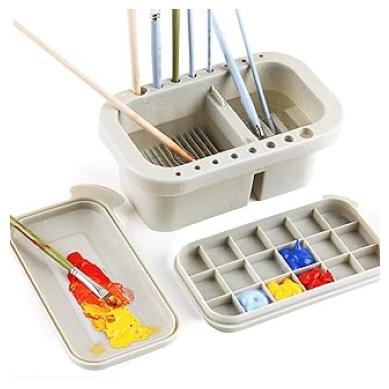

Image Index:  225
Predict:  
best wicker patio furniture set with outdoor table and chairs for 2 people
True: best choice products outdoor rope woven sectional patio furniture l-shaped conversation sofa set for backyard


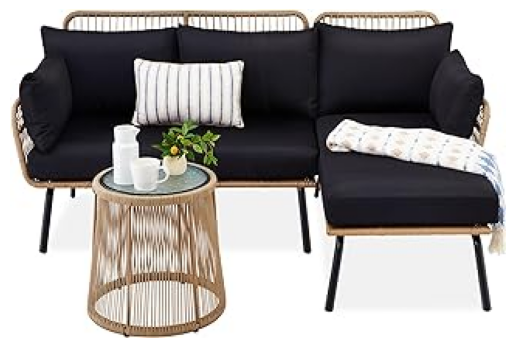

Image Index:  459
Predict:  
blackdecker programmable coffee maker with easy to drink cup holder for
True: mr. coffee 12 cup dishwashable coffee maker with advanced water filtration permanent filter


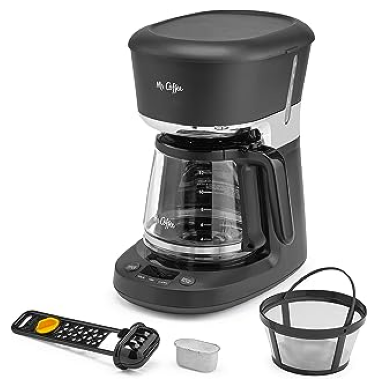

Image Index:  284
Predict:  
indigo laptop desk travel bag - easy to carry and fold up with
True: vecave large travel backpack for women


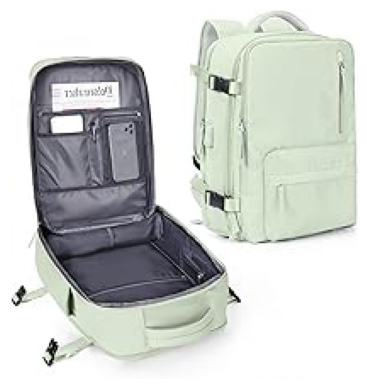

Image Index:  6
Predict:  
utronic hdr 4 k lightning cable 2.
True: gizga essentials laptop power cable cord- 3 pin adapter isi certified


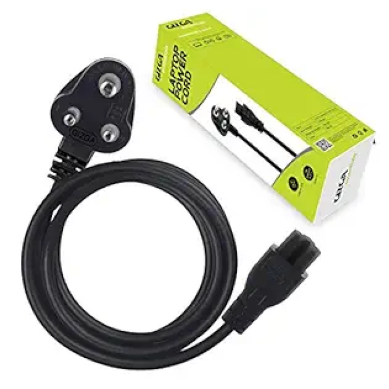

Image Index:  163
Predict:  
crime and punishment deluxe hardbound edition of the violent crime series d
True: crime and punishment deluxe hardbound edition


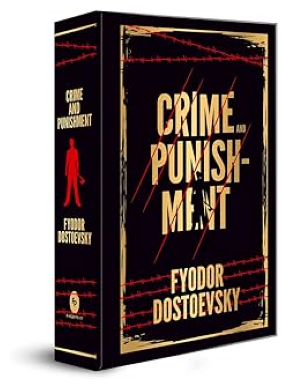

Image Index:  432
Predict:  
cantec baby crib infant bed headboard light industrial vacuum cleaner lamp
True: led dimmable ceiling light modern flower shape ceiling lamp fixture living room bedroom childrens room flu...


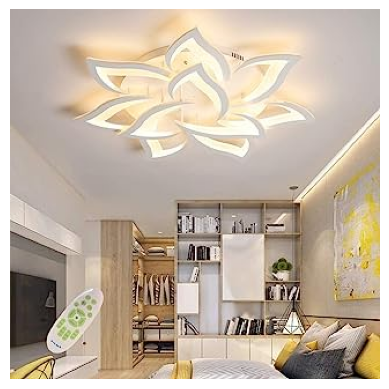

Image Index:  348
Predict:   http://www.
True: 80 s rock down various


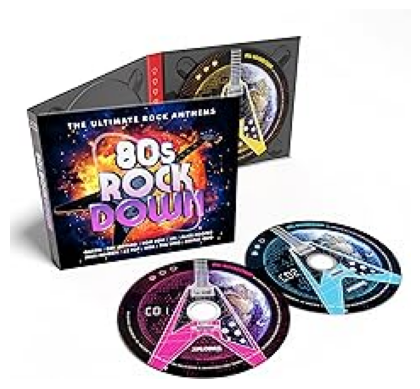

Image Index:  284
Predict:  
indigo laptop travel case for men and women carry-on suitcase with
True: vecave large travel backpack for women


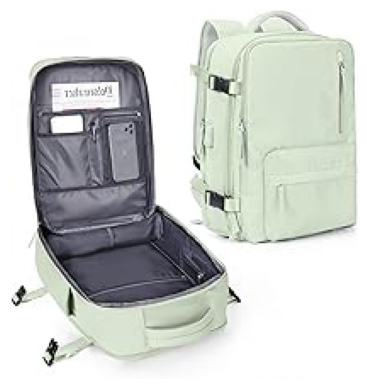

Image Index:  159
Predict:  
bradley womens loafer slip-on leggings casual
True: dr. scholls shoes womens nova sneaker


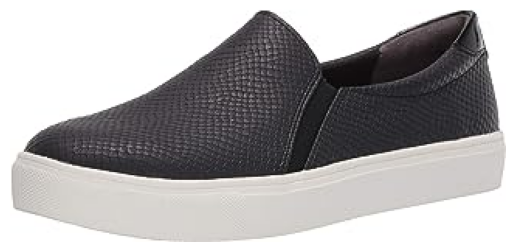

Image Index:  220
Predict:  
hulu bag pajamas kitchen accessories kit with locksmith tools and
True: hlwdflz purple garden tool set gardening gifts for women - 11 pcs heavy duty garden


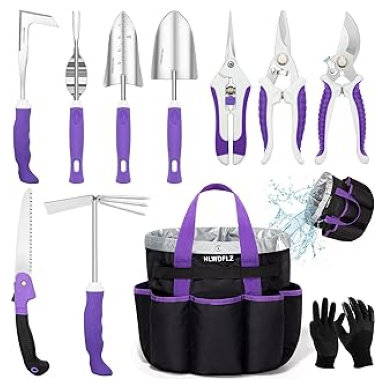

Image Index:  344
Predict:  
taste of home cooked chicken recipes yorkshire puddings a delicious
True: allrecipes 100 best recipes


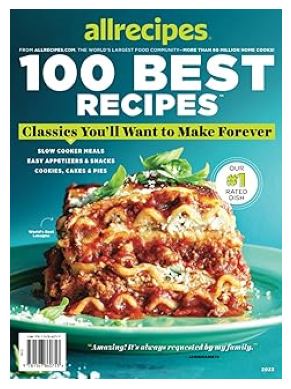

Image Index:  104
Predict:  
blink smart plug-in v2.
True: zorbes wall adapter holder for alexa echo dot 4 th generation


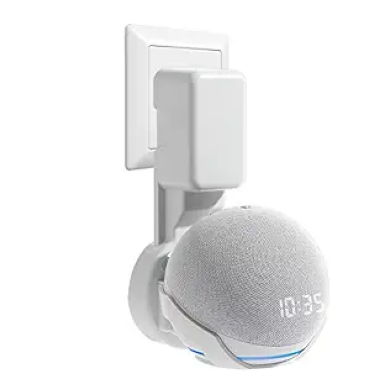

Image Index:  94
Predict:  
noise-fit bluetooth calling smart watch with 1.
True: noise colorfit pro 4 advanced bluetooth calling smart watch with 1.72 truview display


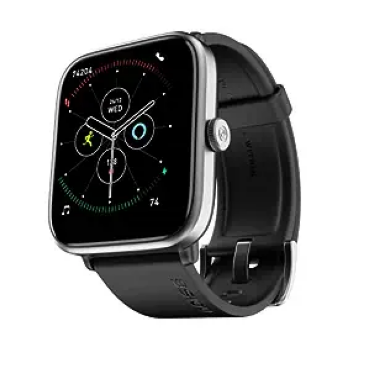

Image Index:  389
Predict:  
chesky 14 k gold plated necklace silver chain necklaces for
True: chesky 14 k goldsilver plated snake chain necklace herringbone necklace gold choker neck


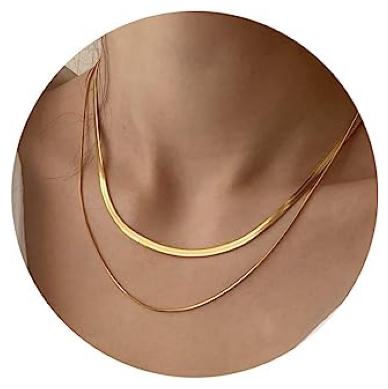

Image Index:  99
Predict:  
fire-boltt smart watch with bluetooth calling 1.
True: noise pulse go buzz smart watch bluetooth calling with 1.69 display


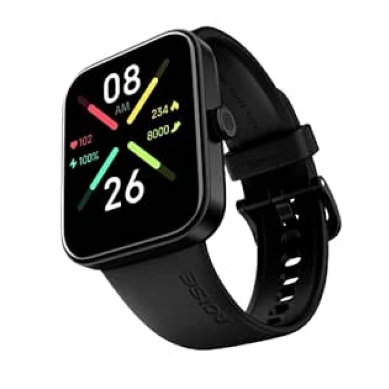

Image Index:  367
Predict:  
automassure womens long sleeve sweater pullover flip flops
True: hanes baby long sleeve bodysuit


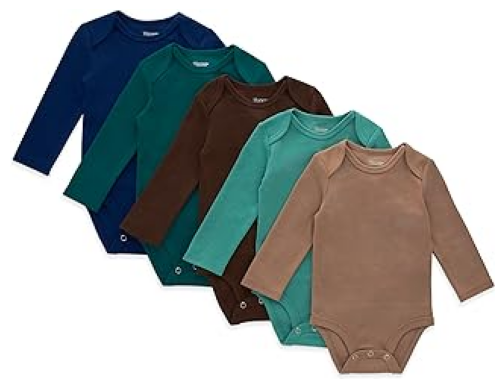

Image Index:  352
Predict:  
enhanceed natural burlesque t-shirt yoga belt vise
True: harrys house


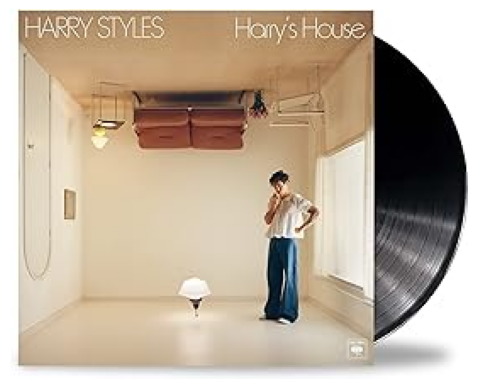

Image Index:  270
Predict:  
avaolite 14 k gold plated pendant necklace for women -
True: swarovski sunshine necklaces and earrings jewelry collection


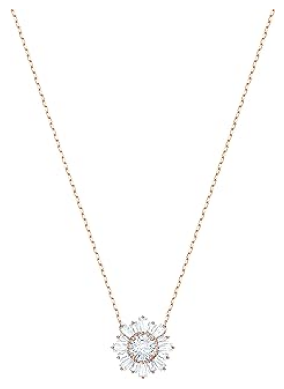

Image Index:  44
Predict:  
hcpio 3-litre instant instanter water heater with
True: havells instanio 10 litre storage water heater with flexi pipe and free installation


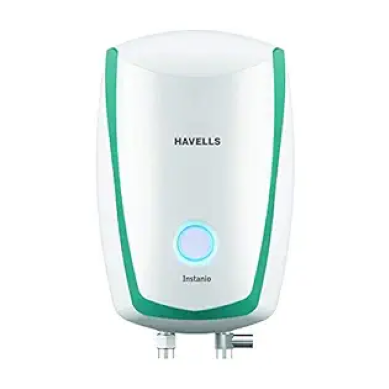

In [ ]:
import random

for i in range(20):
    rand_idx = random.randint(0, len(testset) - 1)
    img, true_text, _ = testset[rand_idx]


    img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
    text = generate_text(model, img_tensor)
    print("Image Index: ", rand_idx)
    print("Predict: ", text)
    print("True:", tokenizer.decode(true_text, skip_special_tokens=True))

    plt.imshow(img); plt.axis('off');plt.show()

##### **Cross Inference**

In [ ]:
!unzip -qq Amazon.zip

In [ ]:
import os

image_dir = 'Amazon'

for filename in os.listdir(image_dir):

    if filename[-3:] in ['jpg', 'png'] or filename[-4:] in ['jpeg']:
        img = Image.open(os.path.join(image_dir, filename)).convert("RGB")


        img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
        text = generate_text(model, img_tensor)

        print("Predict: ", text)

        plt.imshow(img); plt.axis('off');plt.show()

### **Validation Metrics**

**Load Previous Model**

In [ ]:
run = wandb.init()
artifact = run.use_artifact('hungchiehwu/ConvNEXT-GPT2-COCO-amazon-name-v4/model-4te8j53n:v0', type='model')
artifact_dir = artifact.download()

model = ImageCaptioner(image_encoder_model, gpt_model, tokenizer, 0)
checkpoint = torch.load(f"{artifact_dir}/model.ckpt")
model.load_state_dict(checkpoint["state_dict"])

In [ ]:
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate
from tqdm import tqdm

def calculate_metrics(model, testset):
    model = model.to(device)

    #metrics
    total_rouge_scores = 0.0
    total_meteor_scores = 0.0
    total_bleu_scores = 0.0

    rouge = ROUGEScore()
    bleu = BLEUScore(n_gram=1)
    meteor = evaluate.load('meteor')

    for i in tqdm(range(len(testset))):
      img, reference, _ = testset[i]

      img_tensor = image_processor(img, return_tensors="pt").pixel_values[0].to(device)

      text = generate_text(model, img_tensor)
      reference = tokenizer.decode(reference, skip_special_tokens=True)

      total_rouge_scores += rouge(text, reference)['rougeL_fmeasure'].item()
      total_meteor_scores += meteor.compute(predictions=[text], references=[reference])['meteor']
      total_bleu_scores += bleu([text], [[reference]])

      # print(text, reference)


    print("\nRouge Score: {:.2f} Meteor Score: {:.2f} Bleu Score: {:.2f}".format(total_rouge_scores / len(testset) * 100, total_meteor_scores / len(testset) * 100, total_bleu_scores / len(testset) * 100))

In [ ]:
calculate_metrics(model, testset)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 600/600 [06:50<00:00,  1.46it/s]

Rouge Score: 22.17 Meteor Score: 21.07 Bleu Score: 19.24


### **Save Model**

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
train/train_loss,▇▅▅▄▃█▅▄▄▄▄▄▃▃▃▂▂▄▂▃▂▁▂▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
val/val_bleu,▁▃▃▄▅▁▂▃▄▅▅▅▅▆▆▇▇▆█▇█▇▇█▇
val/val_loss,█▆▅▄▄█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val/val_meteor,▁▃▃▄▄▁▂▃▄▄▄▅▅▆▆▆▇▆▇▇█▇███
val/val_rouge,▁▃▄▄▅▁▂▃▄▅▅▅▅▆▆▇▇▆█▇█████
val_loss,█▆▅▄▄█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_metric_mean,▁▃▃▄▄▁▂▃▄▅▄▅▅▆▆▇▇▆█▇█▇███
epoch,19
train/train_loss,2.13399
